# **Supplementary Notebook: Interpretability and Explainability of the BWAF Model**

**Description:**
This notebook provides the complete Python implementation for the interpretability and explainability (XAI) analysis of the **Biologically Weighted Attention Fusion (BWAF)** model. The primary goals are to validate the novel BWAF mechanism, derive biological insights from the model's decisions, and ensure the model's components behave as expected.

**Analyses Performed:**
1.  **Direct Analysis of BWAF Attention Weights (\(\alpha\)):** Correlating the learned fusion weights with the input biological priors.
2.  **Feature Importance with SHAP:** Quantifying the contribution of each motif to the generation of the BWAF attention weights.
3.  **Transformer Self-Attention Visualization:** Analyzing attention maps from the sequence branch to identify focus on known regulatory sites.

---

## **1. Setup: Imports and Configuration**
This first cell installs necessary packages and defines all constants and paths required for the entire notebook. **This cell must be run first.**

In [5]:
# %% 1. Setup: Environment Check, Imports, and Configuration
# ============================================================================

# --- Step 1.1: Dependency Management ---
# This cell ensures compatible library versions to prevent errors like the
# numpy.int AttributeError with older SHAP versions.
import subprocess
import sys
import pkg_resources

def check_and_install_numpy():
    """Checks for a compatible NumPy version (<2.0) and forces it if necessary."""
    try:
        import numpy as np
        from packaging import version
        if version.parse(np.__version__) >= version.parse("2.0.0"):
            print(f"NumPy version {np.__version__} is incompatible. Downgrading to '<2.0'...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2.0", "--quiet"])
            print("\n*** CRITICAL: NumPy has been downgraded. ***")
            print("*** PLEASE RESTART THE KERNEL now for changes to take effect ('Kernel' > 'Restart Kernel'). ***")
            # In a notebook, this will stop the cell execution and prompt the user.
            sys.exit("Kernel restart required to use the correct NumPy version.")
        else:
            print(f"NumPy version {np.__version__} is compatible.")
    except ImportError:
        print("NumPy not found. Installing a compatible version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2.0", "--quiet"])
        print("\n*** NumPy has been installed. PLEASE RESTART THE KERNEL now. ***")
        sys.exit("Kernel restart required.")

# Run the check
check_and_install_numpy()


# --- Step 1.2: Standard Imports ---
import os
import re
import glob
import gzip
import time
import argparse
import datetime
import warnings
import random
import traceback
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shap

try:
    from torch_geometric.nn import GATConv
    from torch_geometric.utils import from_scipy_sparse_matrix
except ImportError:
    print("Warning: PyTorch Geometric might not be fully installed.")

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

print("\n--- Imports Successful ---")
print(f"NumPy Version: {np.__version__}")
print(f"SHAP Version: {shap.__version__}")
print(f"PyTorch Version: {torch.__version__}")
if not hasattr(np, 'int'):
    print("Verification: `np.int` attribute is absent. SHAP should now work correctly.")
else:
    print("Verification Warning: `np.int` attribute still exists. SHAP might still error. Ensure kernel was restarted.")


# --- Step 1.3: Configuration / Constants ---
BASE_DATA_DIR = './data/'
SEQ_DATA_DIR = os.path.join(BASE_DATA_DIR, 'raw/human_genome_annotation')
PRIOR_DATA_DIR = os.path.join(BASE_DATA_DIR, 'raw/human_genome_annotation')
GAT_RAW_DATA_DIR = os.path.join(BASE_DATA_DIR, 'raw/gene_interaction_network/GRAND_networks')
GAT_PREPROCESSED_DIR = os.path.join(BASE_DATA_DIR, 'preprocessed/gat_normalized')
GAT_EDGE_INDEX_DIR = os.path.join(BASE_DATA_DIR, 'preprocessed/gat_edge_indices')
MAIN_BWAF_OUTPUT_DIR = 'results_bwaf_v3/'
TRAINED_MODEL_PATH = os.path.join(MAIN_BWAF_OUTPUT_DIR, 'best_promoter_model_bwaf.pth')
PRECOMPUTED_GAT_PATH = os.path.join(MAIN_BWAF_OUTPUT_DIR, "precomputed_gat_output.pt")
PROMOTER_SEQ_FILE = os.path.join(SEQ_DATA_DIR, 'updated_promoter_features_clean.csv')
NON_PROMOTER_SEQ_FILE = os.path.join(SEQ_DATA_DIR, 'updated_non_promoter_sequences.csv')
PRIOR_FILE = os.path.join(PRIOR_DATA_DIR, 'biological_prior_for_transformer_branch.csv')
OUTPUT_DIR_XAI = 'results_xai/'
os.makedirs(OUTPUT_DIR_XAI, exist_ok=True)
LOG_FILE_XAI = os.path.join(OUTPUT_DIR_XAI, 'xai_analysis_log.txt')
SEQ_LEN=2000; PAD_IDX=4; VOCAB_SIZE=5
EMBEDDING_DIM=64; NUM_ATTN_HEADS=4; NUM_TRANSFORMER_LAYERS=2; TRANSFORMER_FF_DIM=256
NUM_TISSUES_EFFECTIVE=36
GAT_OUTPUT_DIM=64; FUSION_HIDDEN_DIM=128; DROPOUT_RATE=0.3
GAT_INTERACTION_THRESHOLD_STD_FACTOR=2.5; MAX_EDGES_PER_TISSUE_APPROX=1000000
NUM_GAT_LAYERS=1; GAT_HEADS=4; GAT_FINAL_HEADS=1;
VALIDATION_SPLIT=0.15; TEST_SPLIT=0.15; RANDOM_SEED=42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"\nXAI Analysis: Using device: {DEVICE}")

NumPy version 1.26.4 is compatible.

--- Imports Successful ---
NumPy Version: 1.26.4
SHAP Version: 0.41.0
PyTorch Version: 2.7.0+cu126
Verification: `np.int` attribute is absent. SHAP should now work correctly.

XAI Analysis: Using device: cpu


## **2. Definitions: Utility Functions & Model Classes**
This cell contains all necessary class and function definitions. It must be executed after the configuration cell and before the main logic cell. This code is copied from the training script to ensure perfect architectural consistency for loading the trained model.


In [6]:
# %% 2. Definitions and Main Execution for XAI Analysis
# ============================================================================

# --- Step 2.1: Define ALL Helper Functions and Model Classes First ---
# This ensures all definitions are in scope before they are called.

def log_message(message, log_file=LOG_FILE_XAI):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    full_message = f"[{timestamp}] {message}"
    print(full_message)
    log_dir = os.path.dirname(log_file);
    if log_dir and not os.path.exists(log_dir): os.makedirs(log_dir)
    with open(log_file, 'a', encoding='utf-8') as f: f.write(full_message + '\n')

def integer_encode_sequence(sequence, max_len=SEQ_LEN):
    encoding_map={'A':0,'T':1,'C':2,'G':3}; encoded=np.full(max_len,PAD_IDX,dtype=np.int64)
    for i,nuc in enumerate(sequence[:max_len]): encoded[i]=encoding_map.get(nuc.upper(), PAD_IDX)
    return encoded
def log_transform_priors(counts): return np.log1p(np.array(counts,dtype=np.float32))
def extract_clean_gene_id(series): return series.astype(str).str.extract(r'(ENSG\d+)', expand=False).fillna('UNKNOWN')
def load_sequences(file_path, is_promoter=True):
    log_message(f"Loading sequences from {file_path}..."); df=pd.read_csv(file_path); seq_col='promoter_sequence'; id_col='gene_id'
    df=df[df[seq_col].str.len()==SEQ_LEN]; df=df[~df[seq_col].str.contains('N',na=False,case=False)]
    return df[seq_col].tolist(), extract_clean_gene_id(df[id_col]).tolist(), [1 if is_promoter else 0]*len(df)
def load_priors(file_path, gene_id_order):
    log_message(f"Loading priors from {file_path}..."); df=pd.read_csv(file_path); df['clean_gene_id']=extract_clean_gene_id(df['gene_id'])
    count_cols=[c for c in df.columns if '(Count)' in c]; prior_dim=len(count_cols)
    df_priors = df[['clean_gene_id']+count_cols].copy(); df_priors.set_index('clean_gene_id', inplace=True)
    df_priors=df_priors[~df_priors.index.duplicated(keep='first')]; aligned=df_priors.reindex(gene_id_order, fill_value=0)
    return log_transform_priors(aligned.values), prior_dim, count_cols
def _preprocess_and_save_gat_matrix(raw_fp, out_fp, gene_order, master_tfs=None):
    try:
        df_raw=pd.read_csv(raw_fp,index_col=0); tfs=df_raw.index.tolist()
        if master_tfs is None: master_tfs=tfs
        df_tf=df_raw.reindex(index=master_tfs,fill_value=0.0)
        common_genes=[g for g in df_tf.columns if g in set(gene_order)]
        df_g=df_tf[common_genes].reindex(columns=gene_order,fill_value=0.0) if common_genes else pd.DataFrame(0.0,index=master_tfs,columns=gene_order)
        vals=df_g.values.astype(np.float32); min_v,max_v=np.min(vals),np.max(vals); rng=max_v-min_v
        norm_v=np.zeros_like(vals) if rng<1e-9 else (vals-min_v)/(rng+1e-9)
        pd.DataFrame(norm_v,index=master_tfs,columns=gene_order).to_csv(out_fp,compression='gzip')
        return True, master_tfs
    except Exception as e: log_message(f"Error in _preprocess... for {raw_fp}: {e}"); return False, master_tfs
def preprocess_all_gat_data(raw_dir, proc_dir, gene_order, force=False):
    log_message(f"Checking GAT normalized data in {proc_dir}..."); os.makedirs(proc_dir,exist_ok=True)
    raw_files=sorted(glob.glob(os.path.join(raw_dir,'*.csv'))); expected=[os.path.join(proc_dir,f"normalized_{os.path.basename(f)}.gz") for f in raw_files]
    all_exist=all(os.path.exists(f) for f in expected); master_tfs=None
    if all_exist and not force:
        log_message("Verified existing processed GAT files."); df_sample=pd.read_csv(expected[0],index_col=0,compression='gzip'); master_tfs=df_sample.index.tolist()
    else:
        log_message("Processing raw GAT files (filter/normalize)...")
        for raw_fp in tqdm(raw_files,desc="Preprocessing GAT matrices"):
            out_fp=os.path.join(proc_dir,f"normalized_{os.path.basename(raw_fp)}.gz")
            success,tfs_list=_preprocess_and_save_gat_matrix(raw_fp,out_fp,gene_order,master_tfs)
            if success and master_tfs is None: master_tfs=tfs_list; log_message(f"Master TF list set ({len(master_tfs)} TFs).")
    num_tfs=len(master_tfs) if master_tfs else 0; log_message(f"GAT preprocessing check complete. TFs:{num_tfs}, Genes:{len(gene_order)}")
    return num_tfs,len(gene_order),gene_order,master_tfs
def load_processed_gat_data(proc_dir, gene_order, master_tfs):
    log_message(f"Loading processed GAT data..."); files=sorted(glob.glob(os.path.join(proc_dir,'normalized_*.csv.gz')))
    if not files: raise FileNotFoundError(f"No processed GAT files in {proc_dir}")
    mats=[pd.read_csv(f,index_col=0,compression='gzip').reindex(index=master_tfs,columns=gene_order,fill_value=0.0) for f in tqdm(files,desc="Loading normalized GAT")]
    return torch.stack([torch.tensor(df.values,dtype=torch.float32) for df in mats]).mean(dim=0).T, len(master_tfs)
def load_or_create_edge_indices(num_genes,num_tfs,num_tissues,raw_dir,gene_order,edge_dir,std_factor,force_rebuild,max_edges):
    log_message(f"Checking/Creating Edge Indices..."); os.makedirs(edge_dir,exist_ok=True); edge_indices=[]
    raw_files=sorted(glob.glob(os.path.join(raw_dir,'*.csv')))[:num_tissues]
    for raw_path in tqdm(raw_files,desc="Checking/Creating Edge Indices"):
        fname=f"{os.path.basename(raw_path).replace('.csv','')}_gg_th{std_factor:.1f}"+(f"_maxE{max_edges//1000}k" if max_edges else "")+".pt"; edge_file=os.path.join(edge_dir,fname)
        if os.path.exists(edge_file) and not force_rebuild: edge_indices.append(torch.load(edge_file)); continue
        log_message(f"Creating edge index for {os.path.basename(raw_path)}...")
        try:
            df=pd.read_csv(raw_path,index_col=0).reindex(columns=gene_order,fill_value=0.0); abs_s=np.abs(df.values); pairs=set()
            for tf_idx in range(df.shape[0]):
                scores=abs_s[tf_idx,:]; nz=scores[scores>1e-6];
                if nz.size<2: continue
                mean,std=np.mean(nz),max(np.std(nz),1e-3*mean if mean>1e-6 else 0.1); th=mean+std_factor*std
                strong=np.where(scores>th)[0]
                if len(strong)>=2:
                    for i in range(len(strong)):
                        for j in range(i+1,len(strong)): pairs.add(tuple(sorted((strong[i],strong[j]))))
            if max_edges and len(pairs)>max_edges: pairs=set(random.sample(list(pairs),max_edges))
            src,trg=([p[0] for p in pairs],[p[1] for p in pairs]) if pairs else ([],[])
            src.extend(trg); trg.extend(src[:len(trg)])
            edge_idx=torch.tensor([src,trg],dtype=torch.long) if src else torch.empty((2,0),dtype=torch.long)
            torch.save(edge_idx,edge_file); edge_indices.append(edge_idx)
        except Exception as e: log_message(f"Error for {os.path.basename(raw_path)}: {e}"); edge_indices.append(torch.empty((2,0),dtype=torch.long))
    log_message(f"Finished {len(edge_indices)} edge indices.")
    return edge_indices

class MainDataset(Dataset):
    def __init__(self, sequences, gene_ids, labels, priors, gat_output, gat_order):
        self.sequences=torch.tensor(sequences,dtype=torch.int64); self.labels=torch.tensor(labels,dtype=torch.float32).unsqueeze(1)
        self.priors=torch.tensor(priors,dtype=torch.float32); self.gat_output=torch.tensor(gat_output,dtype=torch.float32)
        gat_map={g:i for i,g in enumerate(gat_order)}; self.gat_idx=np.array([gat_map.get(gid,-1) for gid in gene_ids],dtype=np.int64)
    def __len__(self): return len(self.labels)
    def __getitem__(self,idx):
        gat_i=self.gat_idx[idx]; graph_feat=self.gat_output[gat_i] if gat_i!=-1 else torch.zeros(self.gat_output.shape[1])
        return {'sequence':self.sequences[idx],'priors':self.priors[idx],'graph_features':graph_feat,'label':self.labels[idx]}

class TransformerBranch(nn.Module):
    def __init__(self,vocab_size,seq_len,embed_dim,num_heads,ff_dim,num_layers,dropout):
        super().__init__();self.embedding=nn.Embedding(vocab_size,embed_dim,padding_idx=PAD_IDX);self.positional_encoding=nn.Parameter(torch.randn(1,seq_len,embed_dim));self.embed_dropout=nn.Dropout(p=dropout)
        encoder_layer=nn.TransformerEncoderLayer(d_model=embed_dim,nhead=num_heads,dim_feedforward=ff_dim,dropout=dropout,activation='relu',batch_first=True,norm_first=True)
        self.transformer_encoder=nn.TransformerEncoder(encoder_layer,num_layers);self.fusion_prep_layer=nn.Sequential(nn.LayerNorm(embed_dim),nn.Linear(embed_dim,embed_dim),nn.ReLU(),nn.Dropout(p=dropout))
    def forward(self,seq_data):
        x=self.embedding(seq_data)+self.positional_encoding[:,:seq_data.size(1),:];x=self.embed_dropout(x);padding_mask=(seq_data==PAD_IDX)
        transformer_output=self.transformer_encoder(x,src_key_padding_mask=padding_mask);mask=(~padding_mask).unsqueeze(-1).float()
        agg_output=(transformer_output*mask).sum(dim=1)/mask.sum(dim=1).clamp(min=1.0)
        return self.fusion_prep_layer(agg_output)

class GATLayer(nn.Module):
    def __init__(self,in_channels,out_channels,heads,dropout,concat,activation_fn,add_self_loops):
        super().__init__();self.activation_fn=activation_fn;self.gat_conv=GATConv(in_channels,out_channels,heads,dropout=dropout,concat=concat,add_self_loops=add_self_loops,negative_slope=0.2);self.concat=concat;self.out_channels_per_head=out_channels
    def forward(self,x,edge_index):h=self.gat_conv(x,edge_index);return self.activation_fn(h) if self.activation_fn else h
    def get_output_dim(self):return self.out_channels_per_head*self.gat_conv.heads if self.concat else self.out_channels_per_head

class GATNetwork(nn.Module):
    def __init__(self, num_genes_nodes, initial_node_feature_dim, num_tissues_to_process, hidden_dim, num_layers, heads, final_heads, dropout):
        super().__init__();self.num_layers=num_layers;self.layers=nn.ModuleList();self.dropout_layer=nn.Dropout(p=dropout);self.num_tissues_to_process = num_tissues_to_process
        in_channels=initial_node_feature_dim
        for i in range(num_layers):
            is_final=(i==num_layers-1);current_heads=final_heads if is_final else heads;concat=not is_final
            out_ch=hidden_dim//current_heads if concat else hidden_dim
            if concat and hidden_dim%current_heads!=0:raise ValueError("hidden_dim must be divisible by heads")
            self.layers.append(GATLayer(in_channels=in_channels,out_channels=out_ch,heads=current_heads,dropout=dropout,concat=concat,activation_fn=F.elu if not is_final else None,add_self_loops=True))
            in_channels=self.layers[-1].get_output_dim()
        self.final_output_dim=in_channels
    def forward(self,x_node,edge_indices_list):
        files_to_process=min(len(edge_indices_list),self.num_tissues_to_process);outputs=[]
        for i in range(files_to_process):
            h=x_node;edge_index=edge_indices_list[i]
            if edge_index is None or edge_index.numel()==0 or (x_node.shape[0]>0 and edge_index.max().item()>=x_node.shape[0]):
                outputs.append(torch.zeros(x_node.shape[0],self.final_output_dim,device=x_node.device));continue
            for k,layer in enumerate(self.layers):h=layer(h,edge_index);
            if k<self.num_layers-1:h=self.dropout_layer(h)
            outputs.append(h)
        return torch.mean(torch.stack(outputs),dim=0) if outputs else torch.zeros(x_node.shape[0],self.final_output_dim,device=x_node.device)

class BWAFusionLayer(nn.Module):
    def __init__(self,seq_dim,graph_dim,prior_dim,common_feature_dim,fusion_hidden_dim,dropout):
        super().__init__();self.prior_dim=prior_dim;self.common_feature_dim=common_feature_dim
        self.project_seq=nn.Linear(seq_dim,common_feature_dim) if seq_dim!=common_feature_dim else nn.Identity()
        self.project_graph=nn.Linear(graph_dim,common_feature_dim) if graph_dim!=common_feature_dim else nn.Identity()
        attn_in=max(1,prior_dim);attn_hid=max(16,attn_in//2)
        self.weight_generator_seq=nn.Sequential(nn.Linear(attn_in,attn_hid),nn.ReLU(),nn.Linear(attn_hid,1))
        self.weight_generator_graph=nn.Sequential(nn.Linear(attn_in,attn_hid),nn.ReLU(),nn.Linear(attn_hid,1))
        final_dim=common_feature_dim+prior_dim;self.layer_norm=nn.LayerNorm(final_dim)
        self.fc_block=nn.Sequential(nn.Linear(final_dim,fusion_hidden_dim),nn.ReLU(),nn.Dropout(p=dropout),
                                  nn.Linear(fusion_hidden_dim,fusion_hidden_dim//2),nn.ReLU(),nn.Dropout(p=dropout),
                                  nn.Linear(fusion_hidden_dim//2,1))
    def forward(self,seq_feat,graph_feat,prior_feat):
        if self.prior_dim>0:alpha_s=torch.sigmoid(self.weight_generator_seq(prior_feat));alpha_g=torch.sigmoid(self.weight_generator_graph(prior_feat))
        else:alpha_s=torch.ones_like(seq_feat[:,:1])*0.5;alpha_g=torch.ones_like(graph_feat[:,:1])*0.5
        fused=(alpha_s*self.project_seq(seq_feat))+(alpha_g*self.project_graph(graph_feat))
        priors=prior_feat if self.prior_dim>0 else torch.empty(fused.size(0),0,device=fused.device)
        return self.fc_block(self.layer_norm(torch.cat([fused,priors],dim=1)))

# ---  FullModel Class Definition ---
class FullModel(nn.Module):
    """Integrates Transformer, GAT, and BWAFusionLayer."""
    
    def __init__(self, num_genes, initial_feat_dim, num_tissues, prior_dim,
                 embed_dim, num_heads, ff_dim, trans_layers,
                 gat_hid, gat_layers, gat_heads, gat_final,
                 fusion_hid, dropout):
        super().__init__()
        self.transformer=TransformerBranch(VOCAB_SIZE,SEQ_LEN,embed_dim,num_heads,ff_dim,trans_layers,dropout)
        self.gat=GATNetwork(num_genes,initial_feat_dim,num_tissues,gat_hid,gat_layers,gat_heads,gat_final,dropout)
        self.fusion=BWAFusionLayer(embed_dim,self.gat.final_output_dim,prior_dim,embed_dim,fusion_hid,dropout)
        self.precomp_gat=None; self.gat_device='cpu'

    def precompute_gat(self,x_node,edges,device):
        log_message("Precomputing GAT...");start=time.time();self.gat.eval()
        try:
            with torch.no_grad():
                valid_edges=[e.to(device) for e in edges if e is not None and e.numel()>0]
                if not valid_edges:self.precomp_gat=None;log_message("No valid edges for GAT precomp!");return
                self.precomp_gat=self.gat(x_node.to(device),valid_edges).cpu();self.gat_device=device
        finally:self.gat.train()
        if self.precomp_gat is not None:log_message(f"GAT precomp done. Shape:{self.precomp_gat.shape}. Time:{time.time()-start:.2f}s.")

    def forward(self,batch):
        device=batch['sequence'].device;seq_feat=self.transformer(batch['sequence'])
        if self.precomp_gat is None:
            graph_feat=torch.zeros(seq_feat.size(0),self.gat.final_output_dim,device=device)
        else:
            gat_out_all=self.precomp_gat.to(device);gat_idx=batch['aligned_gat_idx'].to(gat_out_all.device)
            valid_mask=(gat_idx!=-1);valid_idx=gat_idx[valid_mask]
            graph_feat=torch.zeros(seq_feat.size(0),self.gat.final_output_dim,device=device)
            if valid_idx.numel()>0 and gat_out_all.shape[0]>0 and valid_idx.max().item()<gat_out_all.shape[0]:
                graph_feat[valid_mask]=gat_out_all.index_select(0,valid_idx)
        return self.fusion(seq_feat,graph_feat,batch['priors'])

log_message("All necessary functions and model classes have been defined.")

[2025-07-31 19:55:18] All necessary functions and model classes have been defined.


### **Section 3: Loading Data, Generating GAT Features, and Loading Trained Model**
This main logic block orchestrates the entire setup for the XAI analysis. It loads all necessary data, intelligently generating intermediate GAT-related files (`normalized` matrices, `edge_indices`, and the final `precomputed_gat_output.pt`) only if they are missing. Finally, it loads the trained BWAF model from the specified checkpoint, making it ready for interpretation.

In [7]:
# %% 3. Main Logic: Data Loading, Model Setup, and XAI Preparation
# ============================================================================
try:
    # --- Step 3.1: Load Primary Data ---
    log_message("\n--- Step 3.1: Loading and Preparing All Data for Test Set Analysis ---")
    prom_seqs, prom_ids, prom_labels = load_sequences(PROMOTER_SEQ_FILE, True)
    nonprom_seqs, nonprom_ids, nonprom_labels = load_sequences(NON_PROMOTER_SEQ_FILE, False)
    all_seqs_raw = prom_seqs + nonprom_seqs; all_gene_ids = prom_ids + nonprom_ids; all_labels = prom_labels + nonprom_labels
    master_gene_list = pd.Series(all_gene_ids).drop_duplicates().tolist()

    priors_aligned, prior_dim, prior_column_names_raw = load_priors(PRIOR_FILE, master_gene_list)
    gene_to_prior_map = {gid: priors_aligned[i] for i, gid in enumerate(master_gene_list)}
    final_priors_for_ds = np.array([gene_to_prior_map.get(gid, np.zeros(prior_dim, dtype=np.float32)) for gid in all_gene_ids])
    sequences_encoded = np.array([integer_encode_sequence(s) for s in tqdm(all_seqs_raw, desc="Encoding All Seqs")])

    # --- Step 3.2: Generate or Load Precomputed GAT Output ---
    if os.path.exists(PRECOMPUTED_GAT_PATH):
        log_message(f"Loading pre-saved static GAT data from {PRECOMPUTED_GAT_PATH}...")
        PRECOMPUTED_GAT_OUTPUT_STATIC = torch.load(PRECOMPUTED_GAT_PATH, map_location='cpu')
        num_tfs_for_init = 644 # Assume known constant
    else:
        log_message(f"WARNING: Precomputed GAT output not found at {PRECOMPUTED_GAT_PATH}.")
        log_message("Attempting to generate it now...")

        num_tfs_for_init, num_genes_for_init, final_gat_gene_order_gen, master_tfs_list_gen = preprocess_all_gat_data(
            GAT_RAW_DATA_DIR, GAT_PREPROCESSED_DIR, master_gene_list, force_preprocess=False)
        initial_node_features_gen, _ = load_processed_gat_data(GAT_PREPROCESSED_DIR, final_gat_gene_order_gen, master_tfs_list_gen)
        edge_indices_list_gen = load_or_create_edge_indices(
            num_genes=num_genes_for_init, num_tfs=num_tfs_for_init,
            num_tissues=NUM_TISSUES_EFFECTIVE, raw_dir=GAT_RAW_DATA_DIR,
            gene_order=final_gat_gene_order_gen, edge_dir=GAT_EDGE_INDEX_DIR,
            std_factor=GAT_INTERACTION_THRESHOLD_STD_FACTOR, force_rebuild=False, 
            max_edges=MAX_EDGES_PER_TISSUE_APPROX)

        log_message("Initializing temporary model to run GAT precomputation...")
        
        temp_model = FullModel(
            num_genes=num_genes_for_init, initial_feat_dim=num_tfs_for_init,
            num_tissues=NUM_TISSUES_EFFECTIVE, prior_dim=prior_dim,
            embed_dim=EMBEDDING_DIM, num_heads=NUM_ATTN_HEADS,
            ff_dim=TRANSFORMER_FF_DIM, trans_layers=NUM_TRANSFORMER_LAYERS,
            gat_hid=GAT_OUTPUT_DIM, gat_layers=NUM_GAT_LAYERS,
            gat_heads=GAT_HEADS, gat_final=GAT_FINAL_HEADS,
            fusion_hid=FUSION_HIDDEN_DIM, dropout=DROPOUT_RATE)
        
        temp_model.precompute_gat(initial_node_features_gen.to(DEVICE), edge_indices_list_gen, DEVICE)
        
        if temp_model.precomp_gat is not None:
            PRECOMPUTED_GAT_OUTPUT_STATIC = temp_model.precomp_gat.cpu()
            torch.save(PRECOMPUTED_GAT_OUTPUT_STATIC, PRECOMPUTED_GAT_PATH)
            log_message(f"Generated and saved precomputed GAT output to: {PRECOMPUTED_GAT_PATH}")
        else: raise RuntimeError("Failed to generate precomputed GAT output.")
        del temp_model, initial_node_features_gen, edge_indices_list_gen
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    final_gat_gene_order = master_gene_list

    # --- Step 3.3: Create Full Dataset & Test Loader ---
    full_dataset = MainDataset(sequences_encoded, all_gene_ids, all_labels,
                               final_priors_for_ds, PRECOMPUTED_GAT_OUTPUT_STATIC.numpy(), final_gat_gene_order)
    indices = list(range(len(full_dataset))); np.random.seed(RANDOM_SEED); np.random.shuffle(indices)
    test_idx_end = int(np.floor(TEST_SPLIT * len(full_dataset)))
    test_indices = indices[:test_idx_end]
    test_dataset = Subset(full_dataset, test_indices)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    log_message(f"Test dataset ready with {len(test_dataset)} samples.")

    # --- Step 3.4: Load Trained BWAF Model for Analysis ---
    log_message("\n--- Step 3.4: Loading Trained BWAF Model for XAI Analysis ---")
    num_genes_in_gat_data = PRECOMPUTED_GAT_OUTPUT_STATIC.shape[0]
    gat_output_dim_from_data = PRECOMPUTED_GAT_OUTPUT_STATIC.shape[1]

    # <<< FIX IS HERE: Use the corrected, non-conflicting parameter names >>>
    model = FullModel(
        num_genes=num_genes_in_gat_data,
        initial_feat_dim=num_tfs_for_init,
        num_tissues=NUM_TISSUES_EFFECTIVE,
        prior_dim=prior_dim,
        embed_dim=EMBEDDING_DIM, 
        num_heads=NUM_ATTN_HEADS,
        ff_dim=TRANSFORMER_FF_DIM, 
        trans_layers=NUM_TRANSFORMER_LAYERS,
        gat_hid=gat_output_dim_from_data, 
        gat_layers=NUM_GAT_LAYERS,
        gat_heads=GAT_HEADS, 
        gat_final=GAT_FINAL_HEADS,
        fusion_hid=FUSION_HIDDEN_DIM, 
        dropout=DROPOUT_RATE
    ).to(DEVICE)

    model.load_state_dict(torch.load(TRAINED_MODEL_PATH, map_location=DEVICE))
    model.precomp_gat = PRECOMPUTED_GAT_OUTPUT_STATIC
    model.eval()
    log_message("Trained BWAF model loaded and ready for interpretability analysis.")

except Exception as e:
    log_message(f"--- DATA/MODEL LOADING FAILED ---")
    log_message(f"ERROR: {type(e).__name__}: {e}")
    log_message("Traceback:\n" + traceback.format_exc())

[2025-07-31 19:55:19] 
--- Step 3.1: Loading and Preparing All Data for Test Set Analysis ---
[2025-07-31 19:55:19] Loading sequences from ./data/raw/human_genome_annotation/updated_promoter_features_clean.csv...
[2025-07-31 19:55:19] Loading sequences from ./data/raw/human_genome_annotation/updated_non_promoter_sequences.csv...
[2025-07-31 19:55:20] Loading priors from ./data/raw/human_genome_annotation/biological_prior_for_transformer_branch.csv...


Encoding All Seqs:   0%|          | 0/40056 [00:00<?, ?it/s]

[2025-07-31 19:55:38] Loading pre-saved static GAT data from results_bwaf_v3/precomputed_gat_output.pt...
[2025-07-31 19:55:38] Test dataset ready with 6008 samples.
[2025-07-31 19:55:38] 
--- Step 3.4: Loading Trained BWAF Model for XAI Analysis ---
[2025-07-31 19:55:38] Trained BWAF model loaded and ready for interpretability analysis.


## **4. I&E Analysis 1: Direct Analysis of BWAF Attention Weights**

**Objective:** Validate if the BWAF mechanism works as intended by examining the learned attention weights (\(\alpha_{seq}, \alpha_{graph}\)) and correlating them with the biological prior features that generated them.

[2025-07-31 19:55:38] Extracting BWAF attention weights ONE SAMPLE AT A TIME for memory efficiency...


Extracting Alpha Weights:   0%|          | 0/47 [00:00<?, ?it/s]

[2025-07-31 20:21:13] Sample-wise extraction complete. Results saved to results_xai/alpha_weights_analysis_data.csv
[2025-07-31 20:21:13] Loading final analysis data from results_xai/alpha_weights_analysis_data.csv...
[2025-07-31 20:21:13] Analysis DataFrame loaded. Shape: (6008, 14)
[2025-07-31 20:21:13] 
--- Correlation between Priors and Learned Alpha Weights ---
Spearman Correlation of Priors with Alpha Weights:
                  alpha_seq  alpha_graph
E-box              0.311815     0.009908
Sp1 Binding Site   0.199223     0.885531
GC Box             0.109395     0.906038
CpG Island         0.059338     0.725611
BRE (TFIIB)        0.023475     0.833404
MRE               -0.024924     0.591076
RFX Binding Site  -0.095345    -0.010297
Octamer Motif     -0.169787    -0.188493
PPE               -0.223275     0.453402
CAAT Box          -0.506985    -0.018576
TATA Box          -0.606830    -0.266612


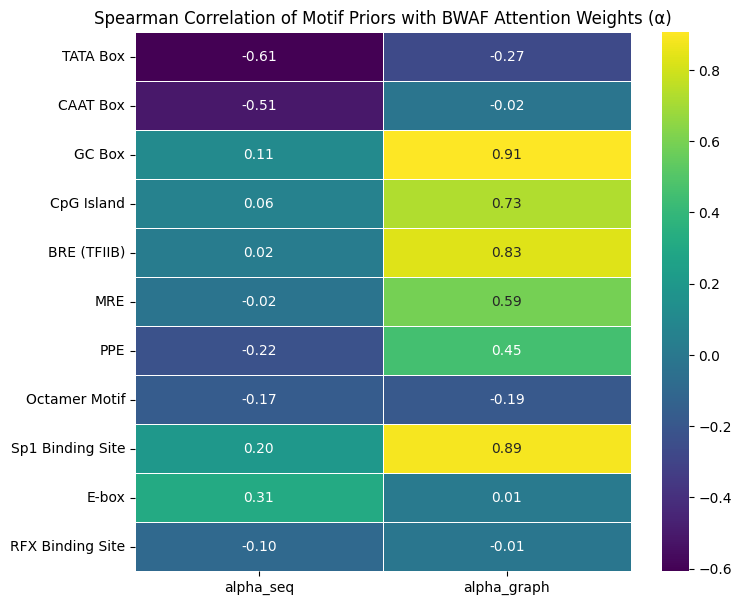

[2025-07-31 20:21:13] 
--- Visualizing Alpha Weight Distributions by Class Label ---


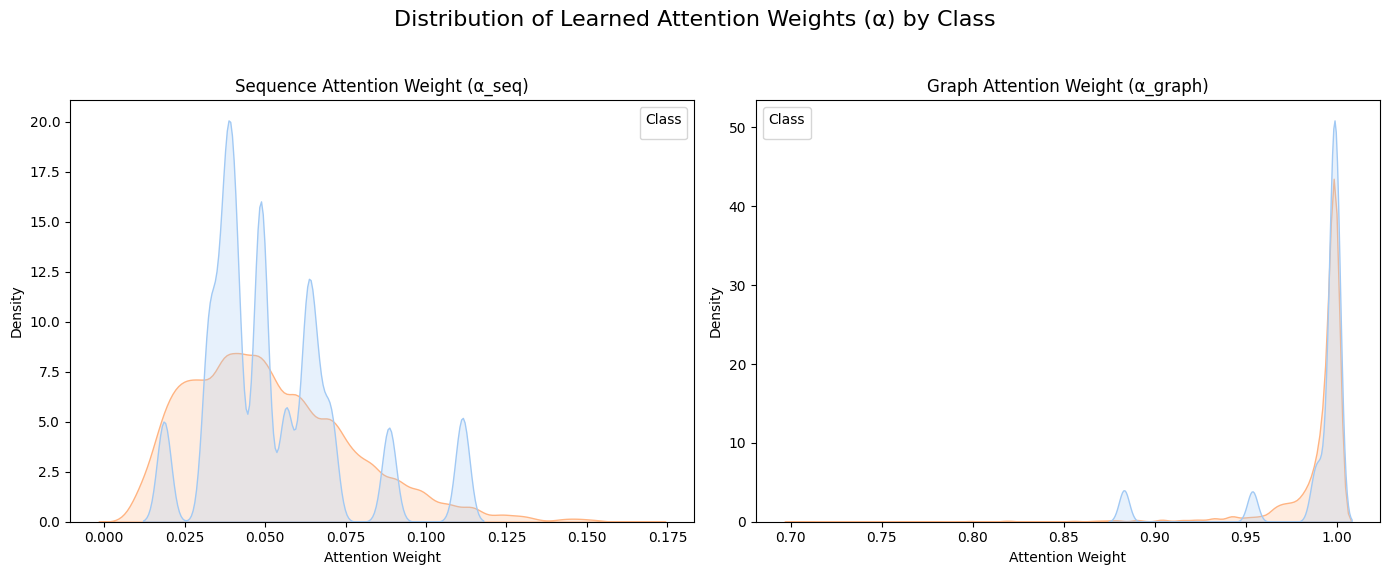

In [8]:
# %% 4. I&E Analysis 1: Direct Analysis of BWAF Attention Weights (Maximum Memory Efficiency)
# ============================================================================

def get_alpha_weights_memory_efficient(model_to_analyze, data_loader, device, prior_column_names, output_dir):
    """
    ULTRA MEMORY EFFICIENT: Processes ONE SAMPLE AT A TIME to avoid batch-related memory spikes.
    Appends results directly to a CSV file on disk.
    Accepts prior_column_names as an argument.
    """
    model_to_analyze.eval()
    
    # Define output path for the analysis data
    output_csv_path = os.path.join(output_dir, "alpha_weights_analysis_data.csv")
    header_written = False
    
    # Temporarily modify the BWAF forward pass to return alphas
    original_bwaf_forward = model_to_analyze.fusion.forward
    
    def modified_bwaf_forward_for_xai(seq_features, graph_features, prior_features):
        if model_to_analyze.fusion.prior_dim > 0:
            alpha_seq = torch.sigmoid(model_to_analyze.fusion.weight_generator_seq(prior_features))
            alpha_graph = torch.sigmoid(model_to_analyze.fusion.weight_generator_graph(prior_features))
        else:
            alpha_seq = torch.ones_like(seq_features[:,:1])*0.5
            alpha_graph = torch.ones_like(graph_features[:,:1])*0.5
        
        logits = original_bwaf_forward(seq_features, graph_features, prior_features)
        return logits, alpha_seq, alpha_graph

    model_to_analyze.fusion.forward = modified_bwaf_forward_for_xai

    log_message("Extracting BWAF attention weights ONE SAMPLE AT A TIME for memory efficiency...")
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Alpha Weights"):
            num_samples_in_batch = batch['sequence'].size(0)
            
            for i in range(num_samples_in_batch):
                # Create a "micro-batch" of size 1
                single_sample_batch = {k: v[i:i+1].to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

                h_seq = model_to_analyze.transformer(single_sample_batch['sequence'])
                h_graph = single_sample_batch['graph_features']
                h_prior = single_sample_batch['priors']
                
                _, alpha_s, alpha_g = model_to_analyze.fusion(h_seq, h_graph, h_prior)
                
                prior_values = h_prior.cpu().numpy().flatten()
                
                # <<< FIX IS HERE: Use the passed-in prior_column_names >>>
                row_data = {col: val for col, val in zip(prior_column_names, prior_values)}
                row_data['alpha_seq'] = alpha_s.item()
                row_data['alpha_graph'] = alpha_g.item()
                row_data['label'] = single_sample_batch['label'].item()
                
                row_df = pd.DataFrame([row_data])

                if not header_written:
                    row_df.to_csv(output_csv_path, index=False, mode='w', header=True)
                    header_written = True
                else:
                    row_df.to_csv(output_csv_path, index=False, mode='a', header=False)

                del single_sample_batch, h_seq, h_graph, h_prior, alpha_s, alpha_g
                if torch.cuda.is_available(): torch.cuda.empty_cache()

    model_to_analyze.fusion.forward = original_bwaf_forward # Restore original forward method
    log_message(f"Sample-wise extraction complete. Results saved to {output_csv_path}")
    return output_csv_path


# --- Main Logic for Analysis 1 ---
# 1. Run the memory-efficient batch processing function
# Get the clean prior column names first
prior_column_names_clean = [col.replace('(Count)', '').strip() for col in prior_column_names_raw]

final_analysis_csv_path = get_alpha_weights_memory_efficient(
    model, 
    test_loader, 
    DEVICE,
    prior_column_names=prior_column_names_clean, # <<< FIX IS HERE: Pass the names
    output_dir=OUTPUT_DIR_XAI
)

# 2. Load the final combined DataFrame from disk for analysis
log_message(f"Loading final analysis data from {final_analysis_csv_path}...")
analysis_df = pd.read_csv(final_analysis_csv_path)
log_message(f"Analysis DataFrame loaded. Shape: {analysis_df.shape}")

# --- 3. Visualize Results (using the final combined analysis_df) ---
log_message("\n--- Correlation between Priors and Learned Alpha Weights ---")
correlation_matrix = analysis_df.corr(method='spearman')
alpha_correlations = correlation_matrix[['alpha_seq', 'alpha_graph']].drop(['alpha_seq', 'alpha_graph', 'label'])
print("Spearman Correlation of Priors with Alpha Weights:")
print(alpha_correlations.sort_values(by='alpha_seq', ascending=False))

plt.figure(figsize=(8, 7))
sns.heatmap(alpha_correlations, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Spearman Correlation of Motif Priors with BWAF Attention Weights (α)')
plt.savefig(os.path.join(OUTPUT_DIR_XAI, 'alpha_prior_correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

log_message("\n--- Visualizing Alpha Weight Distributions by Class Label ---")
plt.figure(figsize=(14, 6))
plt.suptitle("Distribution of Learned Attention Weights (α) by Class", fontsize=16)

plt.subplot(1, 2, 1)
sns.kdeplot(data=analysis_df, x='alpha_seq', hue='label', fill=True, palette="pastel", bw_adjust=0.5)
plt.title('Sequence Attention Weight (α_seq)')
plt.xlabel('Attention Weight')
plt.ylabel('Density')
# Manually create legend for clarity
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Non-Promoter (0)', 'Promoter (1)'], title='Class')


plt.subplot(1, 2, 2)
sns.kdeplot(data=analysis_df, x='alpha_graph', hue='label', fill=True, palette="pastel", bw_adjust=0.5)
plt.title('Graph Attention Weight (α_graph)')
plt.xlabel('Attention Weight')
plt.ylabel('Density')
plt.legend(handles, ['Non-Promoter (0)', 'Promoter (1)'], title='Class')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(OUTPUT_DIR_XAI, 'alpha_weight_distributions.png'), dpi=300)
plt.show()

## **5. I&E Analysis 2: Feature Importance using SHAP**

**Objective:** To quantify which of the 11 biological prior features are most influential in generating the \(\alpha_{seq}\) and \(\alpha_{graph}\) weights."

[2025-07-31 20:21:14] Loading analysis data from results_xai/alpha_weights_analysis_data.csv for SHAP analysis...
[2025-07-31 20:21:14] Loaded 6008 samples with 11 prior features for SHAP.
[2025-07-31 20:21:14] NumPy < 2.0 alias `np.int` not found. Patching with `int` for SHAP compatibility.
[2025-07-31 20:21:14] NumPy < 2.0 alias `np.bool` not found. Patching with `bool` for SHAP compatibility.
[2025-07-31 20:21:14] NumPy < 2.0 alias `np.float` not found. Patching with `float` for SHAP compatibility.
[2025-07-31 20:21:14] Preparing data for SHAP explainer...
[2025-07-31 20:21:14] Calculating SHAP values for alpha_seq... (this may take several minutes)


In the future `np.bool` will be defined as the corresponding NumPy scalar.


  0%|          | 0/500 [00:00<?, ?it/s]

[2025-07-31 20:26:31] Calculating SHAP values for alpha_graph...


  0%|          | 0/500 [00:00<?, ?it/s]

[2025-07-31 20:31:49] Visualizing SHAP summary plots and exporting textual feature importances...


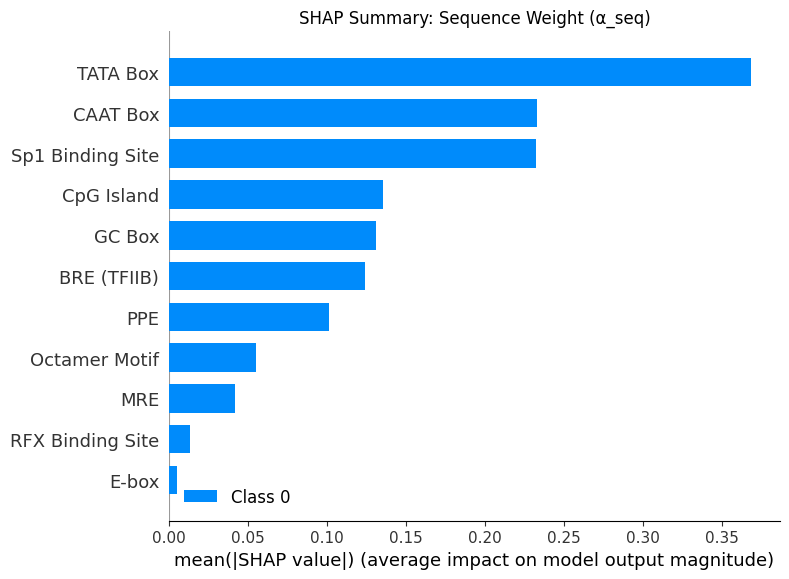


Top SHAP Feature Importances for alpha_seq:
         Feature  MeanAbsSHAP
        TATA Box     0.368219
        CAAT Box     0.233152
Sp1 Binding Site     0.232287
      CpG Island     0.135373
          GC Box     0.131226
     BRE (TFIIB)     0.124204
             PPE     0.101380
   Octamer Motif     0.055148
             MRE     0.041788
RFX Binding Site     0.013498
           E-box     0.005038


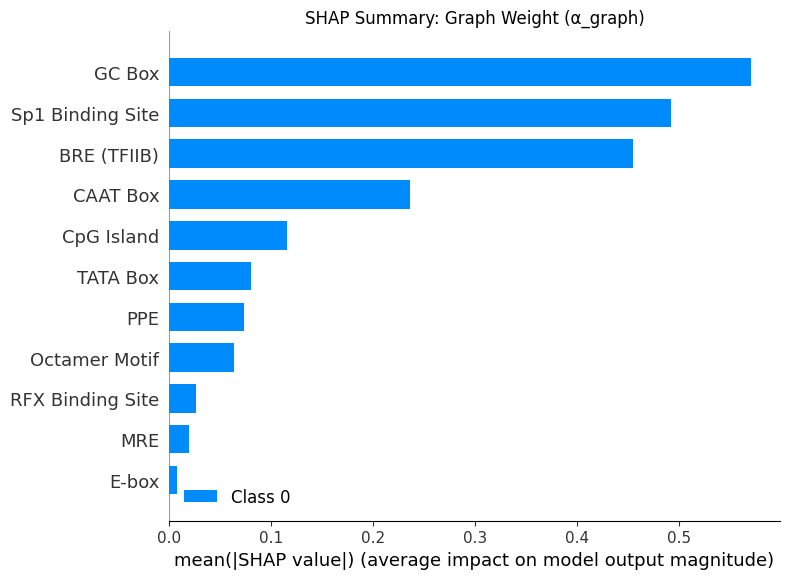


Top SHAP Feature Importances for alpha_graph:
         Feature  MeanAbsSHAP
          GC Box     0.570192
Sp1 Binding Site     0.491924
     BRE (TFIIB)     0.454625
        CAAT Box     0.235875
      CpG Island     0.115434
        TATA Box     0.080393
             PPE     0.073150
   Octamer Motif     0.064131
RFX Binding Site     0.026365
             MRE     0.019957
           E-box     0.007936


In [9]:
# %% 5. I&E Analysis 2: Feature Importance using SHAP
# ============================================================================

# --- Step 5.1: Load the analysis data generated in the previous step ---
analysis_data_path = os.path.join(OUTPUT_DIR_XAI, "alpha_weights_analysis_data.csv")
if not os.path.exists(analysis_data_path):
    raise FileNotFoundError(f"CRITICAL: Analysis data file not found at {analysis_data_path}. "
                            "Please run the 'I&E Analysis 1' cell (Section 4) first to generate it.")

log_message(f"Loading analysis data from {analysis_data_path} for SHAP analysis...")
analysis_df_for_shap = pd.read_csv(analysis_data_path)
prior_column_names_for_shap = [col for col in analysis_df_for_shap.columns if col not in ['alpha_seq', 'alpha_graph', 'label']]
priors_data_for_shap = analysis_df_for_shap[prior_column_names_for_shap].values
log_message(f"Loaded {priors_data_for_shap.shape[0]} samples with {priors_data_for_shap.shape[1]} prior features for SHAP.")


# --- Step 5.2: Create "explainer" functions for SHAP ---
def explain_alpha_func(priors_numpy, model_to_explain, weight_generator_name):
    priors_tensor = torch.tensor(priors_numpy, dtype=torch.float32).to(DEVICE)
    model_to_explain.eval()
    with torch.no_grad():
        weight_generator = getattr(model_to_explain.fusion, weight_generator_name)
        logits = weight_generator(priors_tensor)
    return logits.cpu().numpy()

explain_alpha_seq_func = lambda p: explain_alpha_func(p, model, 'weight_generator_seq')
explain_alpha_graph_func = lambda p: explain_alpha_func(p, model, 'weight_generator_graph')


# --- Step 5.3: Run SHAP analysis ---
if not hasattr(np, 'int'):
    log_message("NumPy < 2.0 alias `np.int` not found. Patching with `int` for SHAP compatibility.")
    np.int = int
if not hasattr(np, 'bool'):
    log_message("NumPy < 2.0 alias `np.bool` not found. Patching with `bool` for SHAP compatibility.")
    np.bool = bool
if not hasattr(np, 'float'):
    log_message("NumPy < 2.0 alias `np.float` not found. Patching with `float` for SHAP compatibility.")
    np.float = float
# =========================================================================

log_message("Preparing data for SHAP explainer...")
background_priors_shap = shap.sample(priors_data_for_shap, 100)
priors_to_explain_shap = shap.sample(priors_data_for_shap, 500)
priors_to_explain_df = pd.DataFrame(priors_to_explain_shap, columns=prior_column_names_for_shap)

# Explain the sequence weight generator
explainer_seq = shap.KernelExplainer(explain_alpha_seq_func, background_priors_shap)
log_message("Calculating SHAP values for alpha_seq... (this may take several minutes)")
shap_values_seq = explainer_seq.shap_values(priors_to_explain_shap)

# Explain the graph weight generator
explainer_graph = shap.KernelExplainer(explain_alpha_graph_func, background_priors_shap)
log_message("Calculating SHAP values for alpha_graph...")
shap_values_graph = explainer_graph.shap_values(priors_to_explain_shap)

# --- Step 5.4: Visualize SHAP results (Summary Plot + Text Export Only) ---
log_message("Visualizing SHAP summary plots and exporting textual feature importances...")

def print_feature_importance_text(shap_values, feature_names, label):
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    print(f"\nTop SHAP Feature Importances for {label}:")
    print(feature_importance_df.to_string(index=False))
    
    feature_importance_df.to_csv(os.path.join(OUTPUT_DIR_XAI, f'shap_importance_{label}.csv'), index=False)
    return feature_importance_df


# ---- SEQ (α_seq) ----
plt.figure()
shap.summary_plot(shap_values_seq, priors_to_explain_df, show=False)
plt.title("SHAP Summary: Sequence Weight (α_seq)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR_XAI, 'shap_summary_alpha_seq.png'), dpi=300)
plt.show()

importance_df_seq = print_feature_importance_text(shap_values_seq, prior_column_names_for_shap, 'alpha_seq')


# ---- GRAPH (α_graph) ----
plt.figure()
shap.summary_plot(shap_values_graph, priors_to_explain_df, show=False)
plt.title("SHAP Summary: Graph Weight (α_graph)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR_XAI, 'shap_summary_alpha_graph.png'), dpi=300)
plt.show()

importance_df_graph = print_feature_importance_text(shap_values_graph, prior_column_names_for_shap, 'alpha_graph')


## **6. I&E Analysis 3: Transformer Attention Visualization**

**Objective:** To verify that the Transformer branch is learning to focus on biologically relevant regions within the DNA sequence.


[2025-07-31 20:31:50] Found example promoter sequence with TATA box at test set index 1

Transformer Attention Visualization Summary
--------------------------------------------------------------------------------
Test Set Index       : 1
Sequence Snippet     : ...TTTCACATGTTATAAAAATAAACTCA...
TATA Box Found       : Yes
TATA Position        : 359 to 365

Top 5 Attention Positions:
Position       Attention Score     
208            0.00992             
96             0.00314             
660            0.00280             
1988           0.00220             
75             0.00209             



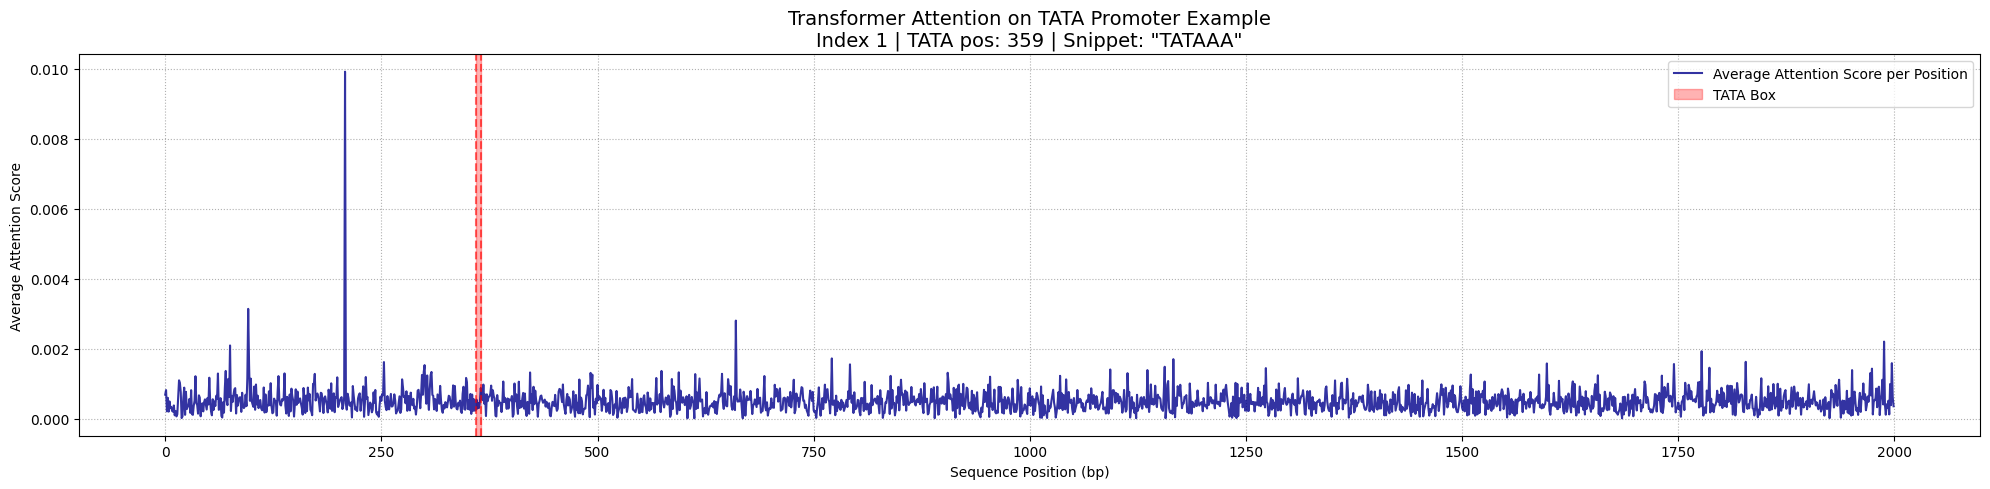

In [10]:
# %% 6. I&E Analysis 3: Transformer Attention Visualization (Manual Forward Pass Method)
# ============================================================================

def get_transformer_attention_manual(model_to_analyze, sequence_tensor_batch):
    """
    Performs a manual forward pass of the Transformer branch to reliably extract
    attention weights from the last layer's Multi-Head Attention module.
    This bypasses PyTorch's internal optimizations that hide attention weights.
    """
    model_to_analyze.eval()
    
    # 1. Get the components from the trained model
    transformer_branch = model_to_analyze.transformer
    embedding_layer = transformer_branch.embedding
    pos_encoding = transformer_branch.positional_encoding
    embed_dropout = transformer_branch.embed_dropout
    encoder_layers = transformer_branch.transformer_encoder.layers
    
    if not encoder_layers:
        log_message("Error: No encoder layers found in the Transformer branch.")
        return None

    # --- Manually perform the forward pass ---
    with torch.no_grad():
        # Move input to the correct device
        seq_data = sequence_tensor_batch.to(DEVICE)
        
        # a) Embedding and Positional Encoding
        x = embedding_layer(seq_data) + pos_encoding[:, :seq_data.size(1), :]
        x = embed_dropout(x)
        
        # b) Pass through all Transformer encoder layers *except the last one*
        for i in range(len(encoder_layers) - 1):
            x = encoder_layers[i](x, src_key_padding_mask=(seq_data == PAD_IDX))
        
        # c) Now, manually execute the forward pass of the *last* encoder layer
        last_encoder_layer = encoder_layers[-1]
        
        # i. Get the MultiheadAttention module
        mha_layer = last_encoder_layer.self_attn
        
        # ii. Get the first normalization layer and dropout
        norm1 = last_encoder_layer.norm1
        dropout1 = last_encoder_layer.dropout1
        
        # iii. Apply the first normalization
        normed_x = norm1(x)
        
        # iv. Call the MultiheadAttention layer directly with need_weights=True
        attn_output, attn_weights = mha_layer(
            normed_x, normed_x, normed_x,  # query, key, value
            key_padding_mask=(seq_data == PAD_IDX),
            need_weights=True,             # This is key to get attention weights
            average_attn_weights=True      # Average across heads
        )
        
        # attn_weights shape: (N, L, L)
        return attn_weights.cpu().detach()


# --- Main Logic for Visualization and Text Output ---
test_raw_sequences = [all_seqs_raw[i] for i in test_indices]
labels_in_test = [all_labels[i] for i in test_indices]

tata_seq_example = None
tata_seq_idx_in_test = -1
for i, seq in enumerate(test_raw_sequences):
    if labels_in_test[i] == 1 and "TATAAA" in seq.upper():
        tata_seq_example = seq
        tata_seq_idx_in_test = i
        break

if tata_seq_example:
    log_message(f"Found example promoter sequence with TATA box at test set index {tata_seq_idx_in_test}")
    
    sample_data = test_dataset[tata_seq_idx_in_test]
    sequence_tensor_for_viz = sample_data['sequence'].unsqueeze(0)  # add batch dim
    
    attn_weights = get_transformer_attention_manual(model, sequence_tensor_for_viz)

    if attn_weights is not None:
        avg_attention_scores = attn_weights[0].mean(dim=0).numpy()
        
        tata_pos = tata_seq_example.upper().find("TATAAA")
        tata_end = tata_pos + 6 if tata_pos != -1 else -1
        context_snippet = tata_seq_example[max(0, tata_pos - 10):tata_end + 10] if tata_pos != -1 else ""

        # Print structured summary
        top_pos = np.argsort(avg_attention_scores)[-5:][::-1]
        top_scores = avg_attention_scores[top_pos]

        print("\n" + "="*80)
        print("Transformer Attention Visualization Summary")
        print("-" * 80)
        print(f"Test Set Index       : {tata_seq_idx_in_test}")
        print(f"Sequence Snippet     : ...{context_snippet}...")
        print(f"TATA Box Found       : {'Yes' if tata_pos != -1 else 'No'}")
        print(f"TATA Position        : {tata_pos} to {tata_end}")
        print("\nTop 5 Attention Positions:")
        print("{:<15}{:<20}".format("Position", "Attention Score"))
        for pos, score in zip(top_pos.tolist(), top_scores.tolist()):
            print("{:<15}{:<20.5f}".format(pos, score))
        print("="*80 + "\n")

        # Plotting
        plt.figure(figsize=(20, 5))
        plt.plot(avg_attention_scores, label='Average Attention Score per Position', color='darkblue', alpha=0.8)

        plt.title(
            f'Transformer Attention on TATA Promoter Example\n'
            f'Index {tata_seq_idx_in_test} | TATA pos: {tata_pos} | Snippet: "{tata_seq_example[tata_pos:tata_end]}"',
            fontsize=14
        )
        plt.xlabel("Sequence Position (bp)")
        plt.ylabel("Average Attention Score")
        plt.grid(True, linestyle=':')

        if tata_pos != -1:
            plt.axvspan(tata_pos, tata_end, color='red', alpha=0.3, label='TATA Box')
            plt.axvline(tata_pos, color='red', linestyle='--', alpha=0.6)
            plt.axvline(tata_end, color='red', linestyle='--', alpha=0.6)

        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR_XAI, 'transformer_attention_visualization.png'), dpi=300)
        plt.show()

    else:
        log_message("Failed to retrieve attention weights.")
else:
    log_message("Could not find a sample promoter sequence with a TATA box in the test set for visualization.")
